# Анализирем все собранные данные, вытащим из них все акты настроки и посмотрим закономерности

In [35]:
import os
import math

import numpy as np
from matplotlib import pyplot as plt

from load_serie import load_all_series
from denoize import create_denoized_spline, build_box_plot
from shot_detector import new_detect_shots
from fragment_iterator import fragment_iterator

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузка данных из всех доступных файлов в папке data

In [37]:
folder = 'data'

# найти все файлы .log в папке folder
files = [f for f in os.listdir(folder) if f.endswith('.log')]

global_series = []
for file in files:
    local_series = load_all_series(os.path.join(folder, file))
    
    count = 0
    for s in filter(lambda s: len(s) > 20, local_series):
        if s[0] != s[-1]:
            global_series.append(s)
            count += 1

    if count > 0:
        print(f'{file}: {count} series')

print(f'Всего {len(global_series)} серий')

freq_11-09-2023_08h-46m.log: 12 series
freq_11-09-2023_08h-50m.log: 91 series
freq_11-09-2023_11h-40m.log: 9 series
freq_11-09-2023_11h-47m.log: 11 series
freq_11-09-2023_11h-50m.log: 4 series
freq_11-09-2023_11h-54m.log: 1 series
freq_11-09-2023_12h-49m.log: 8 series
freq_11-09-2023_12h-54m.log: 14 series
freq_11-09-2023_12h-57m.log: 16 series
freq_11-09-2023_13h-05m.log: 35 series
freq_11-09-2023_13h-32m.log: 5 series
freq_11-09-2023_13h-38m.log: 2 series
freq_14-09-2023_08h-19m.log: 1 series
freq_14-09-2023_08h-50m.log: 4 series
freq_14-09-2023_08h-53m.log: 3 series
freq_14-09-2023_08h-54m.log: 3 series
freq_14-09-2023_08h-57m.log: 8 series
freq_14-09-2023_09h-01m.log: 3 series
freq_14-09-2023_09h-56m.log: 5 series
Всего 235 серий


Находим в данных все акты настройки и собираем их в один список

In [45]:
def move_to_zero(series: list[float]) -> list[float]:
    min_value = min(series)
    return [x - min_value for x in series]


def invalid_fragment(series: list[float]) -> bool:
    max_value = max(series)
    return max_value > 10.0 or series[0] >= series[-1]


def find_fragments_in_serie(serie: list[float], smooth: float = 0.1) -> list[float]:
    dns, _ = create_denoized_spline(serie, smooth)

    values_serie = [dns.Y(p.X) for p in dns.Points[:-2]]
    derivate_serie = [dns.dY(p.X) for p in dns.Points[:-2]]
    derivatire_bxplt = build_box_plot(derivate_serie)

    shots = list(detect_shots(derivate_serie, derivatire_bxplt['lower_bound'], derivatire_bxplt['upper_bound']))
    for shot_n in range(len(shots)):
        if shot_n == len(shots) - 1:
            fragment = values_serie[shots[shot_n]:]
        else:
            fragment = values_serie[shots[shot_n]:shots[shot_n+1]]
        
        zero_bazed_fragment = move_to_zero(fragment)
        if not invalid_fragment(zero_bazed_fragment):
            yield zero_bazed_fragment


def describe_fragment(serie: list[float], smooth: float = 0.1) -> dict[str, float]:
    dns, _s = create_denoized_spline(serie, smooth)

    x = np.linspace(0, len(serie) - 1, len(serie))
    values_serie = np.array([dns(x) for x in x])
    derivate_serie = np.array([dns(x, 1) for x in x])

    shots = list(new_detect_shots(derivate_serie))
    yshots = [serie[i] for i in shots]

    _, ax = plt.subplots(2, 1)
    ax[0].plot(serie, 'b.:', label='orignal values')
    ax[0].plot(values_serie, 'r-', label='smoothed values')
    ax[0].plot(shots, yshots, 'gd', label='shots')
    ax[1].plot(derivate_serie, 'r.--',
             [0] * len(derivate_serie), 'b--')

Тест фрагментов
- 11 - на такое не должно срабатывать
- 25 - нет скачка производной вниз
- 39 - большой кусок с множеством настроечных актов
- 40 - большой кусок с множеством настроечных актов
- 42 - большой кусок, но некоторые акты не распознаны, нет скачка производной вниз
- 45 - Почти все распознано корректно
- 161 - Приемлемо
- 162 - 50/50
- 163 - Хороший результат
- 165 - Почти ни чего не распознано
- 166 - 1 акт распознан каки должно быть

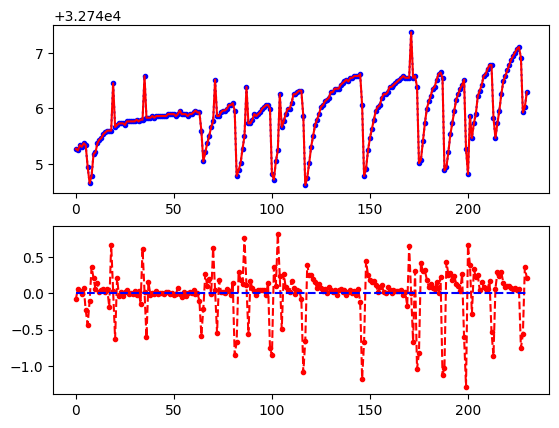

In [144]:
serie_n = 39
st = 510
end = -800
serie = global_series[serie_n]
sl = serie[st:end]

describe_fragment(sl, 0.5)

-> Start: 3, len: 27
-> Start: 54, len: 7
-> Start: 61, len: 18
-> Start: 79, len: 18
-> Start: 97, len: 16
-> Start: 113, len: 30
-> Start: 143, len: 30
-> Start: 171, len: 14
-> Start: 185, len: 12
-> Start: 197, len: 13
-> Start: 210, len: 17


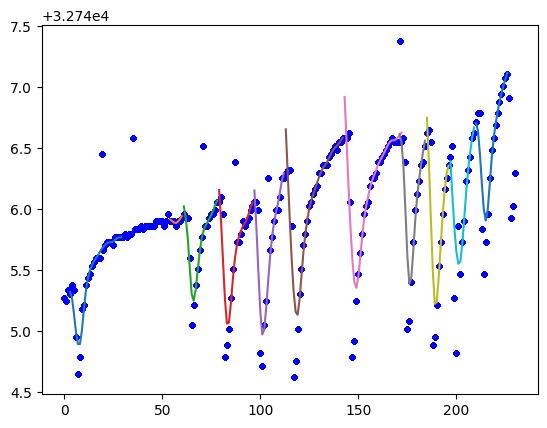

In [118]:
for s in serie:
    plt.plot(sl, 'b.')
generator = iter(sl)
for (start, points) in fragment_iterator(generator, 0.5, 30):
    print(f'-> Start: {start}, len: {len(points)}')
    plt.plot(range(start, start + len(points)), points)

- Обрабатываем все доступные данные, собираем фрагменты в 1 список.
- Вычитаем минимальное значение из всех фрагментов, чтобы все фрагменты начинались с 0
- Отбрасывае фрагменты где частота изменилась слишком сильно > 1.0 Гц
- Отбрасываем фрагменты где частота изменилась слишком слабо < 0.2 Гц
- Отбрасываем фрагменты где частота уменьшилась

In [159]:
global_fragments = []

for i, serie in enumerate(global_series):
    generator = iter(serie)
    for (start, points) in fragment_iterator(generator, 0.5, 30):
        _min = min(points)
        _max = max(points)
        if _max - _min > 1.0 or \
            _max - _min < 0.2 or \
            points[0] >= points[-1]:
            continue
        points = np.array(points) - _min
        global_fragments.append(points)
        
print(f'Всего {len(global_fragments)} фрагментов')

Всего 259 фрагментов


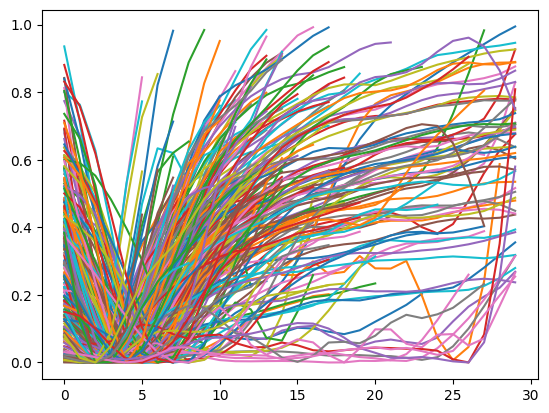

In [163]:
for i, fragment in enumerate(global_fragments[:]):
    plt.plot(fragment, '-')

Все еще слишком много кривых фрагментов, отбросим:
- такие у которых производная в последней точке > 0.1

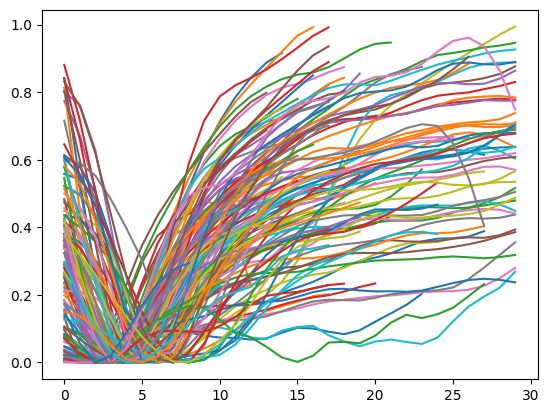

In [162]:
def drop_invalid_fragment(fragment: list[float]) -> bool:
    dns, _ = create_denoized_spline(fragment, 0.5)
    derivative = [dns(x, 1) for x in range(len(fragment))]
    
    return derivative[-1] < 0.04


fragments = list(filter(drop_invalid_fragment, global_fragments))

for fragment in fragments[:]:
    plt.plot(fragment, '-')

Теперь состыкуем их так чтобы минимумы были в одной точке

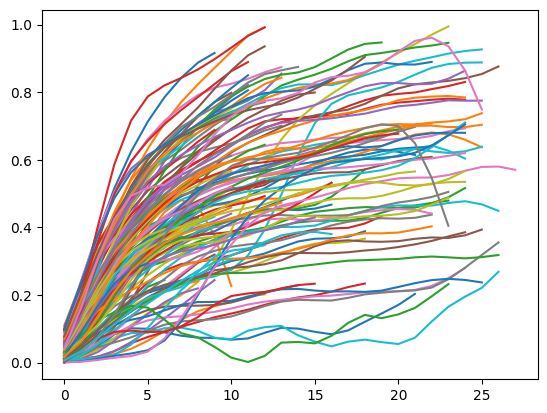

In [171]:
def number_of_furst_min(fragment: list[float]) -> int:
    min = fragment[0]
    for i, y in enumerate(fragment[1:]):
        if y > min:
            return i + 1
        else:
            min = y
    return 0

mins_numbers = [number_of_furst_min(fragment) for fragment in fragments]
moved_fragments = [fragment[min_number:] for fragment, min_number in zip(fragments, mins_numbers)]

for fragment in moved_fragments[:]:
    plt.plot(fragment, '-')

Теперь надо построить диаграмму рассеяния.
Пройдемся по всем книвым и для каждного X построим ящики вероятного Y, если точка отсутвует, то и черт с ней

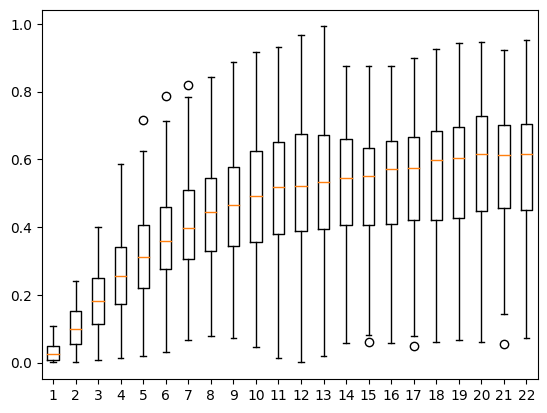

In [172]:
max_len = max([len(fragment) for fragment in moved_fragments])
limuit = max_len * 4 // 5

columns = []
for x in range(limuit):
    col = []
    for fragment in moved_fragments:
        if x < len(fragment):
            col.append(fragment[x])
    columns.append(col)
    
_ = plt.boxplot(columns)